# 2 Perceptron vs Neural Networks
Student ID: 35224436 | Full name: Yiming Zhang

## Question 2 Neural Network’s Decision Boundary

### Task I

#### Load Data

In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# paths
train_path = "/Users/2m/Documents/Monash/FIT5201/Assignment/ML_ASS/ASS2/Dataset_S2_2025/Task2B_train.csv"
test_path = "/Users/2m/Documents/Monash/FIT5201/Assignment/ML_ASS/ASS2/Dataset_S2_2025/Task2B_test.csv"

# load
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# columns
feat_cols = [c for c in train.columns if c.lower().startswith("feature")]
label_col = "label" if "label" in train.columns else train.columns[-1]

# map labels from {0,1} to {-1,+1}
_mapping = {0: -1, 1: 1}
if set(train[label_col].unique()) <= set(_mapping.keys()):
    train[label_col] = train[label_col].map(_mapping).astype(int)
if set(test[label_col].unique()) <= set(_mapping.keys()):
    test[label_col] = test[label_col].map(_mapping).astype(int)

labels_all = sorted(set(train[label_col]) | set(test[label_col]))

# print info
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Columns:", list(train.columns))
print("Label values (train):", sorted(train[label_col].unique()))
print("Label values (test):", sorted(test[label_col].unique()))

Train shape: (500, 3)
Test shape: (2000, 3)
Columns: ['feature1', 'feature2', 'label']
Label values (train): [-1, 1]
Label values (test): [-1, 1]


#### Plot Function

In [245]:
def plot_train_test_scatter(train_df, test_df, feat_cols, label_col, labels_all=None):
    labels_all = sorted(set(train_df[label_col]) | set(test_df[label_col])) if labels_all is None else labels_all
    cmap = plt.get_cmap('Set3', len(labels_all))
    label_to_idx = {lab: i for i, lab in enumerate(labels_all)}

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

    # helper: single panel
    def _panel(ax, df, title):
        for lab in labels_all:
            m = df[label_col] == lab
            ax.scatter(df.loc[m, feat_cols[0]], df.loc[m, feat_cols[1]],
                       color=cmap(label_to_idx[lab]), label=f'Label {lab}',
                       alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
        # (0, 0)
        ax.scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
        ax.set_title(title)
        ax.set_xlabel(feat_cols[0])
        ax.set_ylabel(feat_cols[1])
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
        ax.legend(title=None)

    _panel(axs[0], train_df, 'Training data')
    _panel(axs[1], test_df, 'Testing data')
    plt.show()



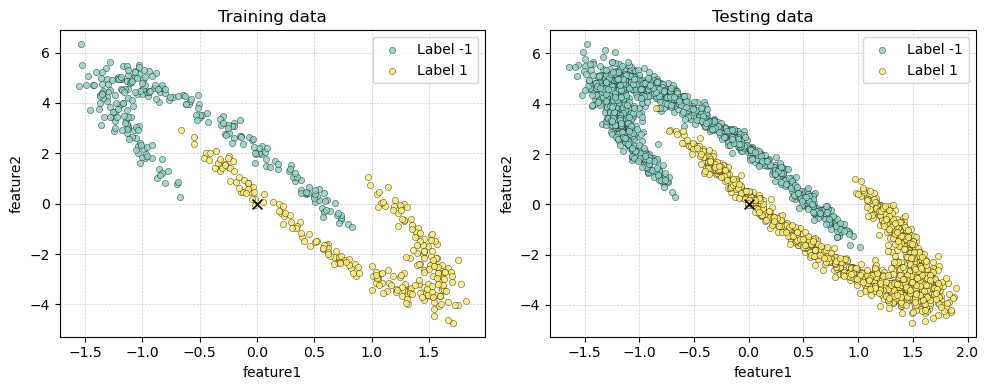

In [246]:
plot_train_test_scatter(train, test, feat_cols, label_col)

### Task II
Train two Perceptron models on the provided training data: one with early stopping and
one without.

#### Perceptron Implementation

#### Parameters Fine-tuning & Validation

In [247]:
from sklearn.linear_model import Perceptron

# prepare data
X = train[feat_cols].values
Y = train[label_col].values
X_test = test[feat_cols].values
Y_test = test[label_col].values


# coercion to {-1,+1}
def to_pm1(a):
    a = np.asarray(a)
    u = set(np.unique(a))
    if u.issubset({0, 1}):
        return np.where(a == 1, 1, -1)
    return a.astype(int)


# error on test
def test_error(model, X, y):
    y_pred = to_pm1(model.predict(X))
    y_true = to_pm1(y)
    return (y_pred != y_true).mean()


etas = [0.001, 0.01, 0.1]
lams = [0.0001, 0.001, 0.01, 0.1, 1.0]

results_no_es = []
results_es = []

for eta in etas:
    for lam in lams:
        # without early stopping
        m0 = Perceptron(
            penalty="l2",
            alpha=lam,
            fit_intercept=True,
            max_iter=2000,
            tol=0.001,
            shuffle=True,
            eta0=eta,
            random_state=42,
            early_stopping=False,
        )
        m0.fit(X, Y)
        err0 = test_error(m0, X_test, Y_test)
        results_no_es.append({"eta": eta, "lam": lam, "test_err": err0, "model": m0})

        # with early stopping
        m1 = Perceptron(
            penalty="l2",
            alpha=lam,
            fit_intercept=True,
            max_iter=2000,
            tol=0.001,
            shuffle=True,
            eta0=eta,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.2,
        )
        m1.fit(X, Y)
        err1 = test_error(m1, X_test, Y_test)
        results_es.append({"eta": eta, "lam": lam, "test_err": err1, "model": m1})

# select best
best_no_es = min(results_no_es, key=lambda r: r["test_err"])
best_es = min(results_es, key=lambda r: r["test_err"])

print(
    "No Early stopping best:",
    {
        "eta": best_no_es["eta"],
        "lam": best_no_es["lam"],
        "test_err": best_no_es["test_err"],
    },
)
print(
    "Early stopping best:",
    {"eta": best_es["eta"], "lam": best_es["lam"], "test_err": best_es["test_err"]},
)

best_model_no_es = best_no_es["model"]
best_model_es = best_es["model"]

No Early stopping best: {'eta': 0.1, 'lam': 0.1, 'test_err': 0.1245}
Early stopping best: {'eta': 0.1, 'lam': 1.0, 'test_err': 0.1235}


#### Plot Function
Plot showing the best models with and without early stopping and their decision boundaries

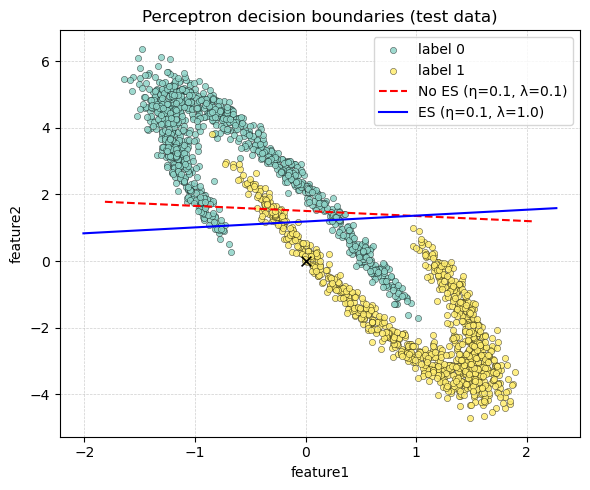

In [248]:
# linear decision boundary: w1*x + w2*y + b = 0
def plot_line_from_w(ax, w, color, linestyle='-', label=None, b=0.0):
    eps = 1e-12
    if abs(w[1]) < eps:
        x0 = -b / w[0] if abs(w[0]) > eps else 0.0
        ax.plot([x0, x0], ax.get_ylim(), linestyle=linestyle, color=color, label=label)
    else:
        xlim = ax.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 200)
        y = -(w[0] * x + b) / w[1]
        ax.plot(x, y, linestyle=linestyle, color=color, label=label)

labels_all = sorted(test[label_col].unique())  # {-1,+1}
lab_name = { -1: 'label 0', 1: 'label 1' }
cmap = plt.get_cmap('Set3', len(labels_all))
label_to_idx = {lab: i for i, lab in enumerate(labels_all)}

fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)

# Test data scatter
for lab in labels_all:
    m = test[label_col] == lab
    ax.scatter(test.loc[m, feat_cols[0]], test.loc[m, feat_cols[1]],
               color=cmap(label_to_idx[lab]), label=lab_name.get(lab, str(lab)),
               alpha=0.85, edgecolors='black', linewidths=0.3, s=20)

# Origin marker
ax.scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)

# Decision boundaries on the same axis (sklearn Perceptron coef_/intercept_)
plot_line_from_w(
    ax, best_model_no_es.coef_.ravel(), color='red', linestyle='--',
    label=f'No ES (η={best_no_es["eta"]}, λ={best_no_es["lam"]})',
    b=float(best_model_no_es.intercept_[0])
)
plot_line_from_w(
    ax, best_model_es.coef_.ravel(), color='blue', linestyle='-',
    label=f'ES (η={best_es["eta"]}, λ={best_es["lam"]})',
    b=float(best_model_es.intercept_[0])
)

ax.set_title('Perceptron decision boundaries (test data)')
ax.set_xlabel(feat_cols[0])
ax.set_ylabel(feat_cols[1])
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(title=None)

plt.show()



### Task III

#### Parameters Fine-tuning & Validation

In [249]:
from sklearn.neural_network import MLPClassifier

# Grid search: λ ∈ {0.001, 1.0}, K ∈ {5..40 step 5}, η ∈ {0.001, 0.01, 0.1}
X_tr = train[feat_cols].values
Y_tr = (train[label_col].values == 1).astype(int)
X_te = test[feat_cols].values
Y_te = (test[label_col].values == 1).astype(int)

lams = [0.001, 1.0]
K_list = list(range(5, 41, 5))  # [5, 10, 15, 20, 25, 30, 35, 40]
etas = [0.001, 0.01, 0.1]

results = []
best_by_lam = {}

for lam in lams:
    best = None
    for K in K_list:
        for eta in etas:
            model = MLPClassifier(
                hidden_layer_sizes=K,
                alpha=lam,
                max_iter=1000,
                learning_rate_init=eta,
                activation="logistic",
                random_state=1234,
            )
            model.fit(X_tr, Y_tr)
            y_pred = model.predict(X_te)
            test_err = (y_pred.ravel() != Y_te.ravel()).mean()
            results.append(
                {
                    "lam": lam,
                    "K": K,
                    "eta": eta,
                    "test_err": float(test_err),
                    "model": model,
                }
            )
            if (best is None) or (test_err < best["test_err"]):
                best = {
                    "lam": lam,
                    "K": K,
                    "eta": eta,
                    "test_err": float(test_err),
                    "model": model,
                }
    best_by_lam[lam] = best

# Save best models for plotting
best_lam_0001 = best_by_lam.get(0.001)
best_lam_1p0 = best_by_lam.get(1.0)

# Formatted summary of best configurations
print("=" * 60)
print(f"λ = 0.001:")
print(f"  - Best K:        {best_lam_0001['K']}")
print(f"  - Best eta:      {best_lam_0001['eta']}")
print(f"  - Test error:    {best_lam_0001['test_err']:.4f}")
print(f"λ = 1.0:")
print(f"  - Best K:        {best_lam_1p0['K']}")
print(f"  - Best eta:      {best_lam_1p0['eta']}")
print(f"  - Test error:    {best_lam_1p0['test_err']:.4f}")
print("=" * 60)

λ = 0.001:
  - Best K:        5
  - Best eta:      0.1
  - Test error:    0.0015
λ = 1.0:
  - Best K:        30
  - Best eta:      0.1
  - Test error:    0.1200


#### Plot Function


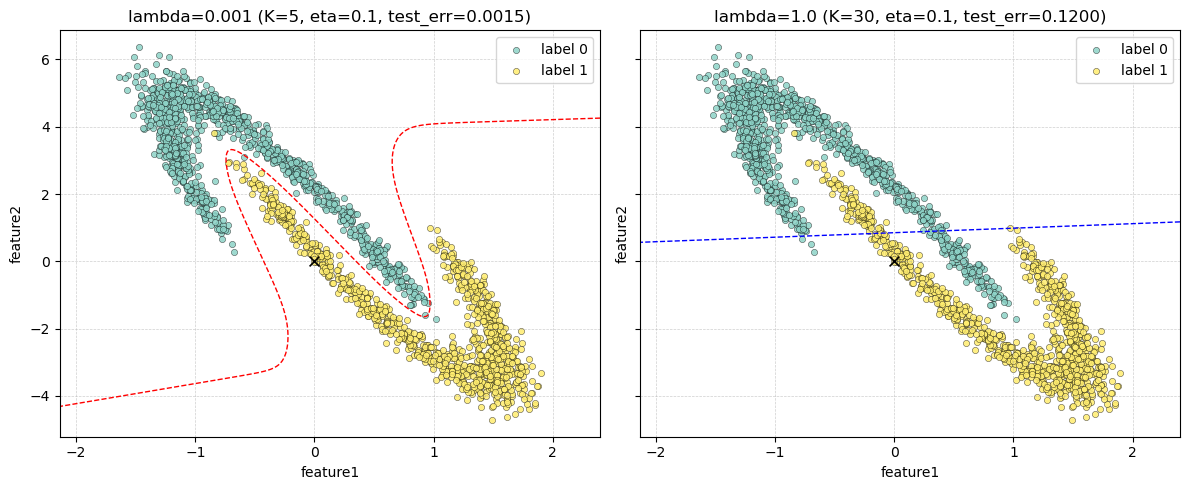

In [250]:
# Plot decision boundaries (matching Task II style exactly)
# Reuse Task II styling
labels_all_nn = sorted(np.unique(Y_te.ravel()))  # {0, 1}
lab_name_nn = {0: "label 0", 1: "label 1"}
cmap_nn = plt.get_cmap("Set3", len(labels_all_nn))
label_to_idx_nn = {lab: i for i, lab in enumerate(labels_all_nn)}

fig, axs = plt.subplots(
    1, 2, figsize=(12, 5), tight_layout=True, sharex=True, sharey=True
)


# Helper function to plot NN decision boundary
def plot_nn_boundary(ax, model, boundary_color, title):
    x_min = X_te[:, 0].min() - 0.5
    x_max = X_te[:, 0].max() + 0.5
    y_min = X_te[:, 1].min() - 0.5
    y_max = X_te[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Decision boundary line
    ax.contour(
        xx,
        yy,
        zz,
        levels=[0.5],
        colors=boundary_color,
        linewidths=1.0,
        linestyles="--",
    )

    # Test data scatter
    for lab in labels_all_nn:
        m = Y_te.ravel() == lab
        ax.scatter(
            X_te[m, 0],
            X_te[m, 1],
            color=cmap_nn(label_to_idx_nn[lab]),
            label=lab_name_nn.get(lab, str(lab)),
            alpha=0.85,
            edgecolors="black",
            linewidths=0.3,
            s=20,
        )

    ax.scatter([0], [0], marker="x", color="black", s=50, linewidths=1.2, zorder=5)
    ax.set_title(title)
    ax.set_xlabel(feat_cols[0])
    ax.set_ylabel(feat_cols[1])
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
    ax.legend(title=None)


# Left: lambda=0.001
plot_nn_boundary(
    axs[0],
    best_lam_0001["model"],
    boundary_color="red",
    title=f"lambda=0.001 (K={best_lam_0001['K']}, eta={best_lam_0001['eta']}, test_err={best_lam_0001['test_err']:.4f})",
)

# Right: lambda=1.0
plot_nn_boundary(
    axs[1],
    best_lam_1p0["model"],
    boundary_color="blue",
    title=f"lambda=1.0 (K={best_lam_1p0['K']}, eta={best_lam_1p0['eta']}, test_err={best_lam_1p0['test_err']:.4f})",
)

plt.show()

#### Explanation

From the results, The 3-layer neural network with $\lambda=0.001$, K = 5, and $\eta=0.1$ performs better.
Its lower regularisation strength allows the model to learn a non-linear decision boundary that fits the complex structure of the data, achieving lower test error (0.0015).
The model with λ = 1.0 is over-regularised — its boundary becomes nearly linear, limiting learning capacity and leading to underfitting.



### Task IV

#### Differences

For **Perceptron models** (both with and without early stopping) show a straight-line decision boundary, which cleanly separates the two classes only in roughly linear regions.

For *3-layer neural networks*, especially with smaller regularisation ($\lambda=0.001$), produce a curved, non-linear boundary that follows the true data distribution more closely.

However, when $\lambda=1.0$ (stronger regularisation), the NN’s boundary becomes almost linear again, showing underfitting.

#### Reasons

The main reason for the difference between the Perceptron and Neural Network comes from their underlying principles and representational power.

The Perceptron follows a linear model, computing a weighted sum of inputs followed by a step activation function $f(x) = \text{sign}(w^T x + b)$. This means it can only form a linear decision boundary, separating data with a single hyperplane. Once the data are not linearly separable, the Perceptron cannot correctly classify them regardless of how it is trained.

In contrast, the Neural Network introduces hidden layers and non-linear activation functions (e.g., Sigmoid, ReLU or tanh), which allow it to perform multiple linear transformations and non-linear mappings in sequence. This hierarchical composition enables the network to approximate non-linear decision surfaces, effectively capturing the complex structure of the data.

Therefore, in the plots, the Perceptron produces a straight-line boundary, while the Neural Network learns a smooth, curved boundary that fits the data distribution more accurately. 

The smaller regularisation (λ=0.001) further allows the NN to fully utilise its non-linear capacity, whereas stronger regularisation (λ=1.0) constrains its weights, forcing it to behave more like a linear model and resulting in underfitting.